In [1]:
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    y = x > 0
    
    return y.astype(np.int32)
    
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def softmax(x):
    # to prevent overflow
    c = np.max(x)
    exp_a = np.exp(x - c)
    sum_exp_a = np.sum(exp_a)

    return exp_a / sum_exp_a


def mean_squared_error(y_hat, y):
    return 0.5 * np.sum((y_hat - y) ** 2)


def cross_entropy_loss(y_hat, y):
    if y.ndim == 1:
        y = y.reshape(1, t.size)
        y_hat = y_hat.reshape(1, y.size)
        
    return -np.sum(y * np.log(y_hat + 1e-7)) / y_hat.shape[0]


def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val  # 값 복원
        it.iternext()

    return grad


def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
        
    return x

In [2]:
class SimpleMLP():
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params["w1"] = weight_init_std / np.random.randn(input_size, hidden_size)
        self.params["b1"] = np.zeros(hidden_size)
        
        self.params["w2"] = weight_init_std / np.random.randn(hidden_size, output_size)
        self.params["b2"] = np.zeros(output_size)
        
        
    def forward(self, x):
        w1, w2 = self.params["w1"], self.params["w2"]
        b1, b2 = self.params["b1"], self.params["b2"]
        
        a1 = np.dot(x, w1) + b1
        z1 = sigmoid(a1)
        
        a2 = np.dot(z1, w2) + b2
        y_hat = softmax(a2)
        
        return y_hat
    
    
    def get_loss(self, x, y):
        y_hat = self.forward(x)
        
        return cross_entropy_loss(y_hat, y)
    
    
    def get_accuracy(self, x, y):
        y_hat = self.forward(x)
        y_hat = np.argmax(y_hat, axis=1)
        y = np.argmax(y, axis=1)
        
        return np.sum(y_hat == y) / float(x.shape[0])
        
        
    def numerical_gradient(self, x, y):
        loss_w = lambda w: self.get_loss(x, y)
        
        grads = {}
        grads["w1"] = numerical_gradient(loss_w, self.params["w1"])
        grads["b1"] = numerical_gradient(loss_w, self.params["b1"])
        
        grads["w2"] = numerical_gradient(loss_w, self.params["w2"])
        grads["b2"] = numerical_gradient(loss_w, self.params["b2"])
        
        return grads

In [3]:
model = SimpleMLP(input_size=784, hidden_size=100, output_size=10)
model.forward(np.random.rand(1, 784))

array([[0.11334275, 0.11018032, 0.24740632, 0.06764915, 0.08549103,
        0.06003207, 0.1297615 , 0.03025432, 0.04932615, 0.10655639]])

In [4]:
import urllib.request
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = "data"
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
    
def download_mnist():
    for v in key_file.values():
        _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_ont_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNIST 데이터셋 읽기
    
    Parameters
    ----------
    normalize : 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화할지 정한다.
    one_hot_label : 
        one_hot_label이 True면、레이블을 원-핫(one-hot) 배열로 돌려준다.
        one-hot 배열은 예를 들어 [0,0,1,0,0,0,0,0,0,0]처럼 한 원소만 1인 배열이다.
    flatten : 입력 이미지를 1차원 배열로 만들지를 정한다. 
    
    Returns
    -------
    (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_ont_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_ont_hot_label(dataset['test_label'])    
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])


# download_mnist()
(X_train, y_train), (X_test, y_test) = load_mnist(normalize=True, flatten=True, one_hot_label=True)

In [5]:
from tqdm import tqdm

train_loss_list = []

n_iters = 30
train_size = X_train.shape[0]
batch_size = 128
learning_rate = 0.01

for i in tqdm(range(n_iters)):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grads = model.numerical_gradient(X_batch, y_batch)
    
    for key in ("w1", "b1", "w2", "b2"):
        model.params[key] -= learning_rate * grads[key]
        
    loss = model.get_loss(X_batch, y_batch)
    train_loss_list.append(loss)

100%|██████████████████████████████████████████| 30/30 [56:01<00:00, 112.04s/it]


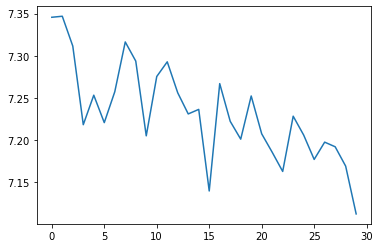

In [6]:
import matplotlib.pyplot as plt 

plt.plot(train_loss_list)
plt.show()